### Storing Data in Parquet

In [1]:
import dask.dataframe as dd

In [3]:

dtypes = {
    'lat': 'object',  # Change to object initially
    'lng': 'object',  # Change to object initially
}

variables = ['Level', 'ClientMacAddr', 'lat', 'lng', 'localtime']

# Read the CSV file with Dask
df = dd.read_csv('combined.csv', usecols=variables, dtype=dtypes)

#df['lat'] = df['lat'].astype(float)
#df['lng'] = df['lng'].astype(float)
df['lng'] = df['lng'].map_partitions(lambda x: pd.to_numeric(x, errors='coerce'))
df['lat'] = df['lat'].map_partitions(lambda x: pd.to_numeric(x, errors='coerce'))

df['localtime'] = dd.to_datetime(df['localtime'], errors='coerce')
df['Level'] = df['Level'].map_partitions(lambda x: x.factorize()[0].astype('int32'))

# df = df.dropna()

In [5]:
df.dtypes

Level                      int32
ClientMacAddr    string[pyarrow]
lat                      Float64
lng                      Float64
localtime         datetime64[ns]
dtype: object

In [5]:
# Write to Parquet
df.to_parquet('kiana.parquet', engine='pyarrow')

### Device Speed Calculation

In [3]:
import dask.dataframe as dd
import dask.array as da
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Function to calculate distance using Haversine formula
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of the Earth in meters
    
    lat1 = da.asarray(lat1, dtype='float64')
    lon1 = da.asarray(lon1, dtype='float64')
    lat2 = da.asarray(lat2, dtype='float64')
    lon2 = da.asarray(lon2, dtype='float64')
    
    # Calculate using Haversine formula
    phi1 = da.radians(lat1)
    phi2 = da.radians(lat2)
    delta_phi = da.radians(lat2 - lat1)
    delta_lambda = da.radians(lon2 - lon1)
    
    a = da.sin(delta_phi / 2) ** 2 + \
        da.cos(phi1) * da.cos(phi2) * \
        da.sin(delta_lambda / 2) ** 2
    c = 2 * da.arctan2(da.sqrt(a), da.sqrt(1 - a))
    
    # Convert result back to Dask Series
    return dd.from_array(R * c)


def process_mobility_data(data_path='kiana.parquet'):
    # Read the data using Dask
    data = dd.read_parquet(data_path)  # Adjust based on input 
    
    # Create metadata for the DataFrame
    initial_meta = {
        'Level': 'int32',
        'ClientMacAddr': 'object',
        'lat': 'float64',
        'lng': 'float64',
        'localtime': 'datetime64[ns]'
    }

    meta = initial_meta.copy()
    meta.update({
        'time_diff': 'float64',
        'prev_latitude': 'float64',
        'prev_longitude': 'float64',
        'distance': 'float64',
        'speed': 'float64'
    })

    # Sort the data
    data = data.map_partitions(
        lambda df: df.sort_values(['ClientMacAddr', 'localtime']),
        meta=initial_meta
    )
    
    # Calculate time difference and previous coordinates
    def process_group(df, partition_info=None):
        if partition_info is not None:
            print(f"Processing partition {partition_info['number']}")
            print(f"Partition {partition_info['number']} size: {len(df)} rows")

        # Sort within each partition
        df = df.sort_values(['ClientMacAddr', 'localtime'])

        # print('calculating time difference in process_group')
        
        # Calculate time difference
        df['time_diff'] = df.groupby('ClientMacAddr')['localtime'].diff().dt.total_seconds() / 60
        
        # print('calculating previous coordinates in process_group')
        
        # Calculate previous coordinates
        df['prev_latitude'] = df.groupby('ClientMacAddr')['lat'].shift()
        df['prev_longitude'] = df.groupby('ClientMacAddr')['lng'].shift()

        # print('calculating Haversine distance in process_group')

        # Calculate distance using Haversine formula
        R = 6371000  # Earth's radius in meters
        
        lat1 = np.radians(df['prev_latitude'])
        lon1 = np.radians(df['prev_longitude'])
        lat2 = np.radians(df['lat'])
        lon2 = np.radians(df['lng'])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        df['distance'] = R * c
        
        # print('calculating speed in process_group')

        # Calculate speed
        df['speed'] = df['distance'] / df['time_diff']
        
        # Drop NaN values
        df = df.dropna()
        
        return df

    print('calling function: process_group')
    
    # Apply all calculations
    data = data.map_partitions(process_group, meta=meta)

    
    data = data.persist()

    print('filtering using time difference')

    # Filter data based on time difference
    data = data[(data['time_diff'] > 0.1) & (data['time_diff'] < 30)]
    
    print('calculating average speed')

    # Calculate average speeds
    average_speeds = data.groupby('ClientMacAddr')['speed'].mean().reset_index()
    average_speeds.columns = ['ClientMacAddr', 'avg_speed']
    
    # Compute to materialize the results
    average_speeds = average_speeds.compute()

    print('performing clustering')

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2, random_state=0)
    average_speeds['mobile'] = kmeans.fit_predict(
        average_speeds[['avg_speed']].values.reshape(-1, 1)
    )
    
    return average_speeds

In [190]:
average_speeds = process_mobility_data()
average_speeds

calling function: process_group
Processing partition 90
Partition 90 size: 608952 rows
Processing partition 97
Partition 97 size: 610673 rows
Processing partition 81
Partition 81 size: 609216 rows
Processing partition 91
Partition 91 size: 609416 rows
Processing partition 92
Partition 92 size: 609744 rows
Processing partition 96
Partition 96 size: 612273 rows
Processing partition 80
Partition 80 size: 608713 rows
Processing partition 84
Partition 84 size: 608948 rows
Processing partition 86
Partition 86 size: 611185 rows
Processing partition 95
Partition 95 size: 609690 rows
Processing partition 87
Partition 87 size: 609049 rows
Processing partition 85
Partition 85 size: 609364 rows
Processing partition 83
Partition 83 size: 609283 rows
Processing partition 93
Partition 93 size: 609448 rows
Processing partition 82
Partition 82 size: 609367 rows
Processing partition 88
Partition 88 size: 609339 rows
Processing partition 8
Partition 8 size: 609540 rows
Processing partition 98
Partition 9

,ClientMacAddr,avg_speed,mobile
0,10:02:b5:e3:08:cd,6.144330,0
1,28:16:ad:17:e3:e6,7.010874,0
2,a4:c3:f0:a5:f0:c8,6.577559,0
3,0c:51:01:b6:45:72,3.710380,0
4,48:45:20:4c:11:89,11.481983,0
...,...,...,...
4155,d0:77:14:fb:bd:59,2.237154,0
4156,d0:77:14:e7:69:55,0.000000,0
4157,cc:44:63:16:3d:be,0.000000,0
4158,08:e6:89:8a:53:c8,0.000000,0


In [132]:
average_speeds = process_mobility_data()
average_speeds

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,ClientMacAddr,avg_speed,mobile
0,00:08:22:24:bd:fb,2.080260,0
1,00:08:22:4e:bb:fb,1.245351,0
2,00:0c:e7:00:a6:9a,3.535431,0
3,00:0c:e7:02:2c:ad,0.000000,0
4,00:0c:e7:02:67:0d,3.520369,0
...,...,...,...
794,f0:0f:ec:73:93:c8,7.332231,0
795,f0:99:19:20:9c:e2,18.428731,1
796,f4:8c:50:1e:a1:31,0.422446,0
797,f8:e9:4e:62:b7:89,0.437640,0


In [256]:
average_speeds.to_csv('average_speeds.csv', index=False)

In [8]:
average_speeds = pd.read_csv('average_speeds.csv')
average_speeds

,ClientMacAddr,avg_speed,mobile
0,10:02:b5:e3:08:cd,6.144330,0
1,28:16:ad:17:e3:e6,7.010874,0
2,a4:c3:f0:a5:f0:c8,6.577559,0
3,0c:51:01:b6:45:72,3.710380,0
4,48:45:20:4c:11:89,11.481983,0
...,...,...,...
123530,d0:77:14:fb:bd:59,2.237154,0
123531,d0:77:14:e7:69:55,0.000000,0
123532,cc:44:63:16:3d:be,0.000000,0
123533,08:e6:89:8a:53:c8,0.000000,0


In [12]:
average_speeds['mobile'] = np.where(average_speeds['avg_speed'] > 1.2, 1, 0)
average_speeds.mobile.value_counts()

mobile
0    91325
1    32210
Name: count, dtype: int64

#### Device Speed Visualization

In [150]:
# Function to plot results
def plot_results(average_speeds):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        range(len(average_speeds)),
        average_speeds['avg_speed'],
        c=average_speeds['mobile'],
        cmap='viridis'
    )
    plt.xlabel('Client Index')
    plt.ylabel('Average Speed (m/min)')
    plt.title('Mobility Classification Results')
    plt.colorbar(label='Cluster')
    plt.show()


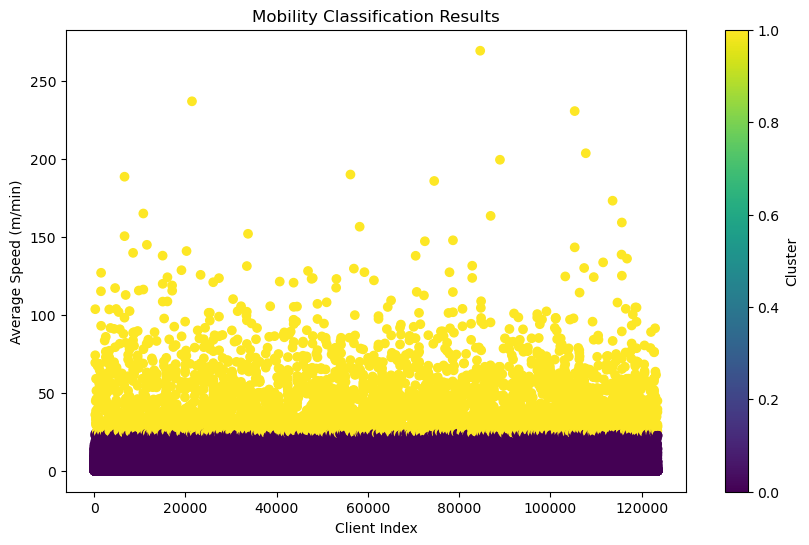

In [192]:
plot_results(average_speeds)

In [210]:
average_speeds['mobile'].value_counts()

mobile
0    120439
1      3096
Name: count, dtype: int64

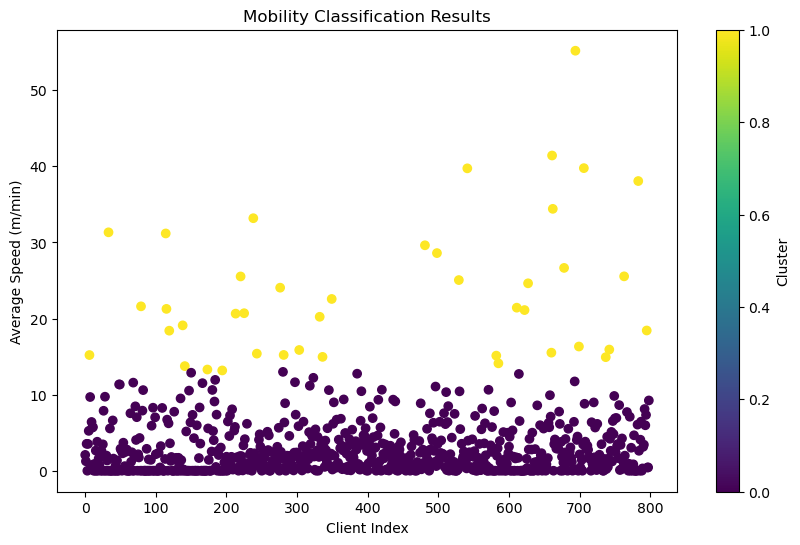

In [152]:
plot_results(average_speeds)

In [252]:
def plot_speed_distribution(average_speeds):
    # Create figure with two subplots
    # Reduced figure size and specified DPI
    plt.rcParams['figure.dpi'] = 100
    fig = plt.figure(figsize=(12, 8))  # Reduced from (18, 12)
    
    # Create gridspec to have better control over spacing
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)
    
    # Create subplots with gridspec
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Histogram with KDE
    counts, bins, patches = ax1.hist(
        average_speeds['avg_speed'],
        bins=200,
        color='skyblue',
        alpha=0.7
    )
    
    # Add KDE plot
    sns.kdeplot(
        data=average_speeds,
        x='avg_speed',
        ax=ax1,
        color='darkblue',
        linewidth=2
    )
    
    # Add labels for bin edges and counts with smaller font
    for i in range(len(bins)-1):
        # Add bin edge labels
        ax1.text(bins[i], -max(counts)*0.05,
                f'{bins[i]:.1f}',
                rotation=45,
                ha='right',
                va='top',
                fontsize=8)
        
        # Add count labels on top of bars
        if counts[i] > 0:  # Only add label if there are items in the bin
            ax1.text((bins[i] + bins[i+1])/2,  # Center of bar
                    counts[i],
                    f'{int(counts[i])}',
                    ha='center',
                    va='bottom',
                    fontsize=8)
    
    # Add last bin edge
    ax1.text(bins[-1], -max(counts)*0.05,
             f'{bins[-1]:.1f}',
             rotation=45,
             ha='right',
             va='top',
             fontsize=8)
    
    # Add mean and median lines
    ax1.axvline(average_speeds['avg_speed'].mean(), color='red', linestyle='--', 
                label=f'Mean: {average_speeds["avg_speed"].mean():.2f}')
    ax1.axvline(average_speeds['avg_speed'].median(), color='green', linestyle='--', 
                label=f'Median: {average_speeds["avg_speed"].median():.2f}')
    
    ax1.set_title('Distribution of Average Speeds', pad=20)
    ax1.set_xlabel('Average Speed (m/min)', labelpad=10)
    ax1.set_ylabel('Count', labelpad=10)
    ax1.set_xlim(0, 5)
    ax1.margins(y=0.15)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Box plot to show statistical summary
    sns.boxplot(
        y=average_speeds['avg_speed'],
        ax=ax2,
        color='skyblue'
    )
    ax2.set_title('Box Plot of Average Speeds', pad=20)
    ax2.set_ylabel('Average Speed (m/min)', labelpad=10)
    ax2.set_ylim(0, 5)
    
    # Add statistical summary as text with adjusted position and font size
    stats_text = (
        f'Mean: {average_speeds["avg_speed"].mean():.2f}\n'
        f'Median: {average_speeds["avg_speed"].median():.2f}\n'
        f'Std Dev: {average_speeds["avg_speed"].std():.2f}\n'
        f'Min: {average_speeds["avg_speed"].min():.2f}\n'
        f'Max: {average_speeds["avg_speed"].max():.2f}\n'
        f'Number of MACs: {len(average_speeds)}\n'
        f'Bin width: {(bins[1] - bins[0]):.2f} m/min'
    )
    
    # Place stats text with smaller font size
    plt.figtext(0.85, 0.5, stats_text,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='center',
                fontsize=8)
    
    # Adjust layout with specific margins
    plt.subplots_adjust(right=0.85,  # Make room for stats text
                       left=0.1,
                       top=0.95,
                       bottom=0.1)
    
    plt.show()

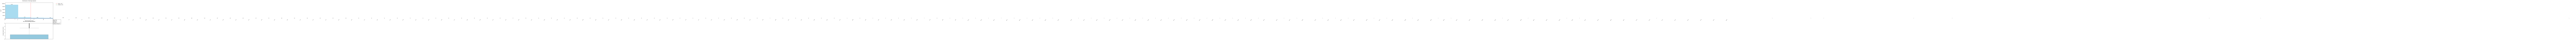

In [254]:
plot_speed_distribution(average_speeds)

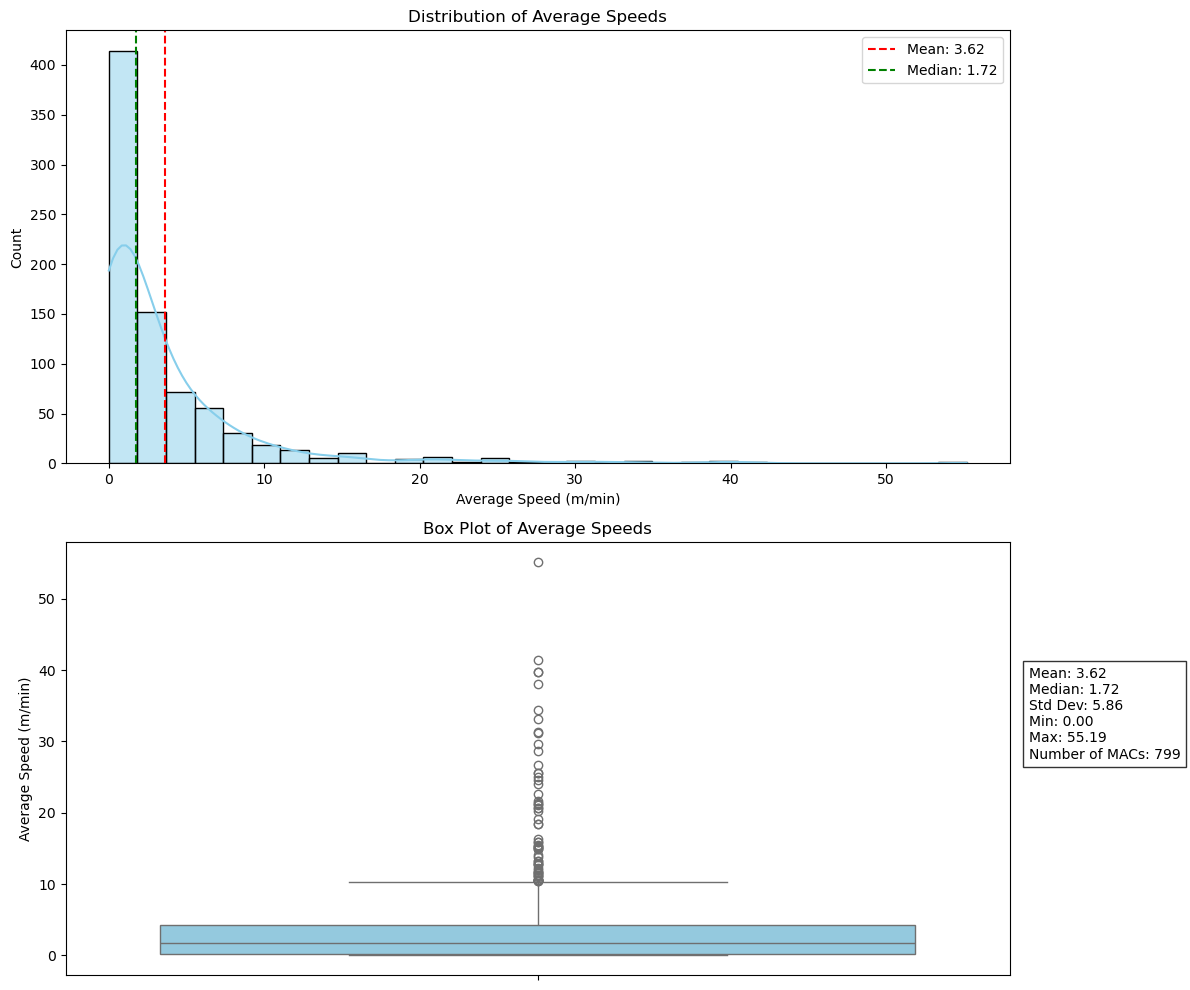

In [158]:
plot_speed_distribution(average_speeds)

## Device Security

In [7]:
from dask.diagnostics import ProgressBar

In [5]:
data_path = 'kiana.parquet'
data = dd.read_parquet(data_path).partitions[:2]

In [11]:
with ProgressBar():
    print("\nAnalyzing merge results...")
    total_rows = data.shape[0].compute()
    
print(f"Total rows in merged data: {total_rows}")


Analyzing merge results...
[########################################] | 100% Completed | 215.38 ms
Total rows in merged data: 1217607


In [23]:
average_speeds.mobile.value_counts()

mobile
0    91325
1    32210
Name: count, dtype: int64

### Device Time Spent

In [45]:
import dask
from dask.diagnostics import ProgressBar

import pandas as pd
import numpy as np

def analyze_transitions(data, average_speeds, transition_threshold=10):
    print("Starting analysis of level transitions...")
    
    # Convert average_speeds to Dask DataFrame if it's not already
    if isinstance(average_speeds, pd.DataFrame):
        average_speeds = dd.from_pandas(average_speeds, npartitions=1)
    
    # Step 1: Merge DataFrames
    print("Merging data...")
    merged_data = dd.merge(data, average_speeds, on='ClientMacAddr', how='inner')
    
    # Step 2: Filter for mobile = 0
    print("Filtering for non-mobile devices...")
    mobile_data = merged_data[merged_data['mobile'] == 0]
    
    # Define metadata for the DataFrame with new columns
    meta = {
        'Level': 'int32',
        'ClientMacAddr': 'object',
        'lat': 'float64',
        'lng': 'float64',
        'localtime': 'datetime64[ns]',
        'avg_speed': 'float64',
        'mobile': 'int64',
        'prev_level': 'int32',
        'level_changed': 'bool',
        'time_diff': 'timedelta64[ns]'
    }
    
    # Step 3: Sort and process data
    def process_partition(df):
        if len(df) == 0:
            return pd.DataFrame(columns=meta.keys())
        
        # Sort within partition
        df = df.sort_values(['ClientMacAddr', 'localtime'])
        
        # Calculate changes for each group
        groups = []
        for _, group in df.groupby('ClientMacAddr'):
            group = group.copy()
            group['prev_level'] = group['Level'].shift(1)
            group['level_changed'] = (group['Level'] != group['prev_level']).astype('bool')
            group['time_diff'] = group['localtime'].diff()
            groups.append(group)
        
        if groups:
            return pd.concat(groups)
        return pd.DataFrame(columns=meta.keys())
    
    print("Processing data...")
    mobile_data = mobile_data.map_partitions(process_partition, meta=meta)
    
    # Step 4: Aggregate transitions
    def aggregate_transitions(df):
        if len(df) == 0:
            return pd.DataFrame({
                'ClientMacAddr': [],
                'transitions': [],
                'total_time': []
            })
        
        # Filter for level changes
        changes = df[df['level_changed']]
        
        # Group by ClientMacAddr and count transitions
        agg = changes.groupby('ClientMacAddr').agg({
            'level_changed': 'sum',
            'time_diff': 'sum'
        }).reset_index()
        
        agg.columns = ['ClientMacAddr', 'transitions', 'total_time']
        return agg
    
    # Define metadata for aggregated results
    agg_meta = {
        'ClientMacAddr': 'object',
        'transitions': 'int64',
        'total_time': 'timedelta64[ns]'
    }
    
    print("Aggregating transitions...")
    transitions = mobile_data.map_partitions(
        aggregate_transitions,
        meta=agg_meta
    )
    
    print("Computing results...")
    with ProgressBar():
        transitions_df = transitions.compute()
    
    # Sort and rank transitions
    transitions_df = transitions_df.sort_values('transitions', ascending=False).reset_index(drop=True)
    transitions_df['rank'] = transitions_df['transitions'].rank(method='dense', ascending=False)
    
    # Identify high transition devices
    high_transition_macs = set(
        transitions_df[transitions_df['transitions'] > transition_threshold]['ClientMacAddr']
    )
    
    # Update mobility classifications
    def update_mobile(df):
        df['mobile'] = np.where(
            df['ClientMacAddr'].isin(high_transition_macs),
            1,
            df['mobile']
        )
        return df
    
    print("Updating mobility classifications...")
    average_speeds = average_speeds.map_partitions(
        update_mobile,
        meta={
            'ClientMacAddr': 'object',
            'avg_speed': 'float64',
            'mobile': 'int64'
        }
    )
    
    with ProgressBar():
        final_speeds = average_speeds.compute()
    
    # Print summary statistics
    print("\nAnalysis Summary:")
    print(f"Total devices analyzed: {len(final_speeds)}")
    print(f"Devices exceeding transition threshold: {len(high_transition_macs)}")
    print(f"Final mobile devices: {(final_speeds['mobile'] == 1).sum()}")
    
    return final_speeds, transitions_df

    
updated_speeds, transition_stats = analyze_transitions(
    data,
    average_speeds,
    transition_threshold=10
)

transition_stats

Starting analysis of level transitions...
Merging data...
Filtering for non-mobile devices...
Processing data...
Aggregating transitions...
Computing results...
[########################################] | 100% Completed | 19m 26s
Updating mobility classifications...
[########################################] | 100% Completed | 107.30 ms

Analysis Summary:
Total devices analyzed: 123535
Devices exceeding transition threshold: 0
Final mobile devices: 32210

devices by transition count:


C:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


KeyError: "['transition_count'] not in index"

In [47]:
transition_stats

,ClientMacAddr,transitions,total_time,rank
0,98:84:e3:d8:80:60,3,94 days 16:51:19.864000,1.0
1,60:64:05:c6:51:76,2,94 days 17:38:34.431000,2.0
2,18:5e:0f:ec:f0:77,2,175 days 23:23:06.826000,2.0
3,98:84:e3:d8:80:60,2,143 days 13:16:30.188000,2.0
4,18:5e:0f:ec:f0:a9,2,89 days 00:01:53.251000,2.0
...,...,...,...,...
200830,80:58:f8:36:56:76,1,0 days 00:00:00,3.0
200831,80:58:f8:36:af:85,1,0 days 00:00:00,3.0
200832,80:58:f8:36:c4:c0,1,0 days 00:00:00,3.0
200833,80:58:f8:36:e8:08,1,0 days 00:00:00,3.0


In [53]:
transition_stats.to_csv('Device Transitions between Levels.csv')

In [55]:
updated_speeds.mobile.value_counts()

mobile
0    91325
1    32210
Name: count, dtype: int64

In [57]:
updated_speeds.to_csv('device_speeds_after_transition.csv')

### Simulation: Employee Data

In [15]:
updated_speeds = pd.read_csv('device_speeds_after_transition.csv')
transition_stats = pd.read_csv('Device Transitions between Levels.csv')

In [86]:
from faker import Faker
import random

from shapely.geometry import Polygon, box, Point


In [67]:
cluster_1_data = updated_speeds[updated_speeds['mobile'] == 1]

# Initialize Faker
fake = Faker('en_US')

# Define a list of realistic job titles
job_titles = [
    "Software Engineer", "Data Scientist", "Project Manager", "Product Manager", "Marketing Specialist",
    "Sales Executive", "Business Analyst", "Financial Analyst", "Graphic Designer", "UX/UI Designer",
    "Network Administrator", "Database Administrator", "Technical Writer", "Systems Analyst", 
    "Human Resources Manager", "Operations Manager", "Legal Consultant", "Customer Service Manager",
    "Quality Assurance Specialist", "Machine Learning Engineer", "Cybersecurity Analyst", "DevOps Engineer",
    "Cloud Architect", "IT Support Specialist", "Digital Marketing Manager", "Content Strategist",
    "SEO Specialist", "E-commerce Manager", "Logistics Coordinator", "Supply Chain Analyst",
    "Product Designer", "Chief Technology Officer", "Chief Marketing Officer", "Social Media Manager",
    "Account Executive", "Corporate Trainer", "Recruitment Specialist", "Copywriter", 
    "Public Relations Manager", "Research Scientist", "Biomedical Engineer", "Mechanical Engineer",
    "Civil Engineer", "Environmental Consultant", "Healthcare Administrator", "Laboratory Technician",
    "Clinical Research Associate", "Data Engineer", "Chief Financial Officer", "Legal Assistant",
    "Janitor", "Security Guard", "Warehouse Worker", "Forklift Operator", "Maintenance Technician",
    "Receptionist", "Administrative Assistant", "Customer Service Representative", "Cashier", 
    "Barista", "Sales Associate", "Warehouse Manager", "Production Worker", "Truck Driver",
    "Office Clerk", "Facilities Manager", "Food Service Worker", "Retail Associate", "Inventory Clerk"
]

# Add random names, job titles, and security levels based on existing ClientMacAddr
cluster_1_data['Name'] = [fake.name() for _ in range(len(cluster_1_data))]
cluster_1_data['Job Title'] = [random.choice(job_titles) for _ in range(len(cluster_1_data))]
cluster_1_data['security_level'] = [random.randint(0, 3) for _ in range(len(cluster_1_data))]

# Select relevant columns to create df_employee
df_employee = cluster_1_data[['ClientMacAddr', 'Name', 'Job Title', 'security_level']]

# Display the first few rows of df_employee
df_employee

C:\Users\ctric\AppData\Local\Temp\ipykernel_484\405056871.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['Name'] = [fake.name() for _ in range(len(cluster_1_data))]
C:\Users\ctric\AppData\Local\Temp\ipykernel_484\405056871.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['Job Title'] = [random.choice(job_titles) for _ in range(len(cluster_1_data))]
C:\Users\ctric\AppData\Local\Temp\ipykernel_484\405056871.py:29: SettingWithCopyWarning: 
A value is trying to be set on 

,ClientMacAddr,Name,Job Title,security_level
0,10:02:b5:e3:08:cd,Susan Mcclure,Office Clerk,1
1,28:16:ad:17:e3:e6,Susan Hall,Sales Associate,3
2,a4:c3:f0:a5:f0:c8,Stephanie Reilly,IT Support Specialist,2
3,0c:51:01:b6:45:72,Gabriel Baxter,Cashier,2
4,48:45:20:4c:11:89,Valerie Roberts,Social Media Manager,0
...,...,...,...,...
123517,24:46:c8:7b:d3:96,Dr. Mark Pham,Technical Writer,0
123520,24:46:c8:9f:3c:e4,Linda Herrera,Chief Financial Officer,2
123527,24:18:1d:a1:8e:c2,Daniel Taylor,Receptionist,1
123528,6c:40:08:9d:ea:02,Justin Lane,Forklift Operator,2


### Security Areas

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Total number of chunks: 46
POLYGON ((51.46045717697546 -0.9327990938367862, 51.46045717697546 -0.9326990938367862, 51.46035717697546 -0.9326990938367862, 51.46035717697546 -0.9327990938367862, 51.46045717697546 -0.9327990938367862))
Selected top security chunk is chunk 14 with bounds (51.46035717697546, -0.9327990938367862, 51.46045717697546, -0.9326990938367862)


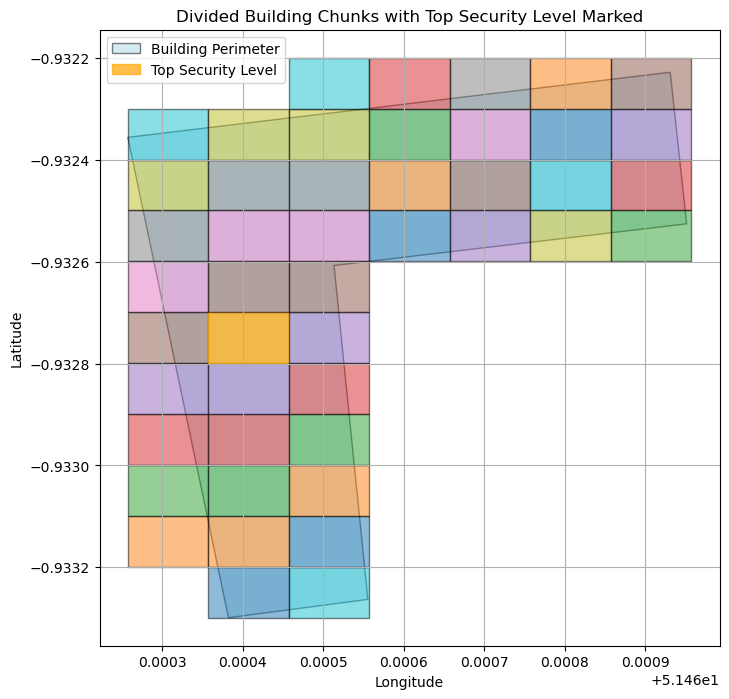

(51.46035717697546,
 -0.9327990938367862,
 51.46045717697546,
 -0.9326990938367862)

In [71]:
# Define corner coordinates (longitude, latitude)
cornor_1 = [51.46095123823644, -0.932525400630025]
cornor_2 = [51.46093076671099, -0.9322276754361255]
cornor_3 = [51.46025717697545, -0.9323554932449286]
cornor_4 = [51.46038217497724, -0.9332990938367861]
cornor_5 = [51.46055530494714, -0.9332630941041455]
cornor_6  = [51.4605132491444, -0.9326072239750992]

# Step 1: Create a Polygon using the corners
corners = [cornor_1, cornor_2, cornor_3, cornor_4, cornor_5, cornor_6]
polygon = Polygon(corners)

# Step 2: Plot the original L-shaped building
x, y = polygon.exterior.xy
plt.figure(figsize=(8, 8))
plt.fill(x, y, alpha=0.5, fc='lightblue', ec='black', label='Building Perimeter')

# Step 3: Create a grid to divide the polygon into chunks
min_lon, min_lat, max_lon, max_lat = polygon.bounds

# Define grid size
grid_size = 0.0001  # Adjust this value to make more or fewer chunks

# Generate grid cells (rectangles) over the bounding box of the polygon
lon_steps = np.arange(min_lon, max_lon, grid_size)
lat_steps = np.arange(min_lat, max_lat, grid_size)

grid_cells = []
for lon in lon_steps:
    for lat in lat_steps:
        cell = box(lon, lat, lon + grid_size, lat + grid_size)  # Create a rectangular cell
        if polygon.intersects(cell):  # Only keep cells that intersect the building polygon
            grid_cells.append(cell)

# Step 4: Debugging: Check how many chunks are created
print(f"Total number of chunks: {len(grid_cells)}")

# Step 5: Set a random seed for reproducibility
random.seed(8)  # Set the seed

# Randomly select one chunk for top security level
random_index = random.randint(0, len(grid_cells) - 1)
top_security_chunk = grid_cells[random_index]
print(top_security_chunk)

# Get the bounds of the top security chunk
top_security_bounds = top_security_chunk.bounds
print(f"Selected top security chunk is chunk {random_index} with bounds {top_security_bounds}")

# Step 6: Plot the divided chunks, highlighting the top security chunk
for i, cell in enumerate(grid_cells):
    x, y = cell.exterior.xy
    if i == random_index:
        plt.fill(x, y, alpha=0.7, ec='red', color='orange', label='Top Security Level')
    else:
        plt.fill(x, y, alpha=0.5, ec='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divided Building Chunks with Top Security Level Marked')
plt.legend()
plt.grid(True)
plt.show()

# Return the boundary coordinates of the top security chunk
top_security_bounds


In [76]:
employee_dask = dd.from_pandas(df_employee, npartitions=1)
merged_data = dd.merge(data.iloc[:, :10000], employee_dask, on='ClientMacAddr')

merged_data.iloc[:, :10000]
# with ProgressBar():
#     print("\nAnalyzing merge results...")
#     total_rows = merged_data.shape[0].compute()
    
# print(f"Total rows in merged data: {total_rows}")


Analyzing merge results...
[########################################] | 100% Completed | 85.19 s
[########################################] | 100% Completed | 82.79 s

Merge Statistics:
Total rows in merged data: 279118697
Rows with matching employee data: 279118697
Rows without matching employee data: 0


In [80]:
merged_data.head()

,Level,ClientMacAddr,lat,lng,localtime,Name,Job Title,security_level
0,0,9c:8c:6e:46:1c:5e,51.460445,-0.933048,2020-09-01 23:58:49.582,Angela Kirby,IT Support Specialist,1
1,0,9c:8c:6e:46:0b:7c,51.460788,-0.932288,2020-09-01 23:58:45.435,Kathleen Patterson,Marketing Specialist,2
2,0,9c:8c:6e:46:1c:5e,51.460445,-0.933048,2020-09-01 23:58:38.112,Angela Kirby,IT Support Specialist,1
3,0,9c:8c:6e:46:0b:7c,51.460782,-0.932292,2020-09-01 23:58:35.379,Kathleen Patterson,Marketing Specialist,2
4,0,9c:8c:6e:46:0b:7c,51.460782,-0.932292,2020-09-01 23:58:29.827,Kathleen Patterson,Marketing Specialist,2


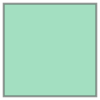

In [90]:
top_security_chunk

In [99]:
def check_for_intruders(mac_data, top_security_chunk):
    intruders = []
    
    for _, entry in mac_data.iterrows():
        mac_position = Point(entry["lat"], entry["lng"])  # Create a Point for the MAC's location
        security_level = entry["security_level"]
        
        # Check if the MAC ID is inside the top security zone
        if top_security_chunk.contains(mac_position) and security_level < 3:
            intruders.append((entry["ClientMacAddr"], security_level))
    
    return intruders

# Get the intruders
intruders = check_for_intruders(merged_data.iloc[:, :10000], top_security_chunk)

unique_intruders = set(intruders)

# Print intruders if any
if unique_intruders:
    for intruder in unique_intruders:
        print(f"ALARM: MAC ID {intruder[0]} (security level {intruder[1]}) is inside the top security area.")
else:
    print("No intruders detected.")


IndentationError: unindent does not match any outer indentation level (<string>, line 7)

In [ ]:
df = sample1

# Convert localtime to datetime
df['localtime'] = pd.to_datetime(df['localtime'], errors='coerce')

# Extract hour and day of week
df['hour'] = df['localtime'].dt.hour
df['day_of_week'] = df['localtime'].dt.dayofweek

df = df.dropna()
df = df.drop(columns=['localtime'])

level_mapping = {
    '1st Floor': 2,
    '2nd Floor': 3,
    '3rd Floor': 4,
    'Ground Floor': 1
}

def encode_level(level):
    return level_mapping.get(level, -1)

df.Level = df.Level.apply(encode_level)

df

In [115]:
df.dtypes

Level              int64
ClientMacAddr     object
lat              float64
lng              float64
hour             float64
day_of_week      float64
dtype: object

In [117]:
threshold = 0.0001

# Group by ClientMacAddr and apply the condition
df = df.groupby('ClientMacAddr').filter(
    lambda x: (x['lat'].max() - x['lat'].min() > threshold) or 
              (x['lng'].max() - x['lng'].min() > threshold)
)

df

,Level,ClientMacAddr,lat,lng,hour,day_of_week
0,2,cc:73:14:60:68:97,51.460419,-0.933088,11.0,3.0
1,1,88:66:a5:1f:0b:05,51.460657,-0.932341,12.0,1.0
3,3,e4:a7:a0:99:dd:51,51.460825,-0.932265,14.0,3.0
4,2,48:45:20:37:d1:6f,51.460465,-0.933087,14.0,3.0
6,2,48:45:20:37:cb:c0,51.460589,-0.932266,9.0,3.0
...,...,...,...,...,...,...
9995,2,48:a4:72:ae:11:5e,51.460488,-0.933043,10.0,1.0
9996,1,88:66:a5:0e:6c:33,51.460589,-0.932388,2.0,4.0
9997,3,34:e1:2d:c6:a8:59,51.460402,-0.932568,18.0,4.0
9998,3,88:66:a5:15:d6:89,51.460823,-0.932265,13.0,2.0


In [25]:
df.ClientMacAddr.nunique()

2120

In [33]:
df_mobile['ClientMacAddr'].nunique()

1070

## Clustering

### Time variables

In [185]:
# Select features for clustering
features = ['hour', 'day_of_week']

# Prepare the data for clustering
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
n_clusters = 6  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [187]:
# Analyze cluster characteristics
cluster_analysis = df.groupby('Cluster').agg({
    'lat': ['mean', 'std'],
    'lng': ['mean', 'std'],
    'hour': ['mean', 'std'],
    'day_of_week': ['mean', 'std'],
    'Level': lambda x: x.mode()[0]
})

cluster_analysis

lat                 lng                 hour            \
              mean       std      mean       std       mean       std   
Cluster                                                                 
0        51.460559  0.000163 -0.932558  0.000285  15.549561  2.354969   
1        51.460527  0.000143 -0.932522  0.000235   7.516035  3.461008   
2        51.460551  0.000159 -0.932532  0.000262  16.726868  2.630667   
3        51.460570  0.000164 -0.932556  0.000293  10.060606  1.634893   
4        51.460522  0.000146 -0.932502  0.000213   2.459397  1.840778   
5        51.460574  0.000169 -0.932558  0.000295  10.981000  1.784441   

        day_of_week              Level  
               mean       std <lambda>  
Cluster                                 
0          0.513802  0.499966        3  
1          4.911079  0.843676        1  
2          3.322613  1.148321        3  
3          0.529966  0.499269        3  
4          1.870070  1.248929        1  
5          2.603500  0.642257        3

In [189]:
cluster_analysis = cluster_analysis.reset_index()

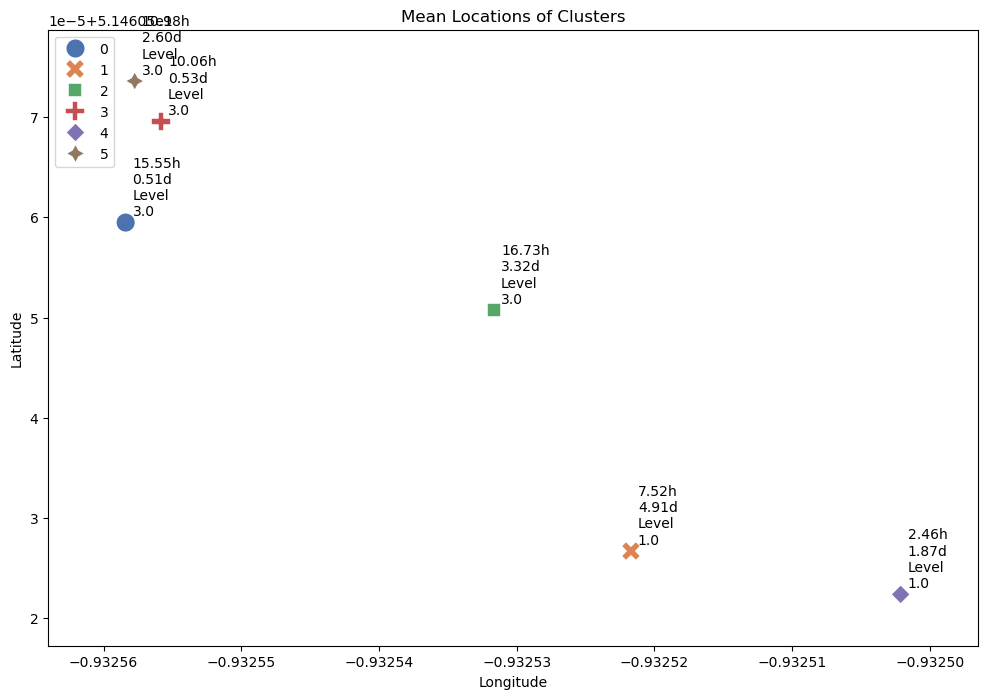

In [191]:
# Create the plot
plt.figure(figsize=(12, 8))

# Create a scatter plot of the mean locations
sns.scatterplot(data=cluster_analysis, x=('lng', 'mean'), y=('lat', 'mean'), 
                hue='Cluster', style='Cluster', s=200, palette='deep')

# Add labels for each point
for idx, row in cluster_analysis.iterrows():
    plt.annotate(f"{row[('hour', 'mean')]:.2f}h\n{row[('day_of_week', 'mean')]:.2f}d\nLevel\n{row[('Level', '<lambda>')]}",
                 (row[('lng', 'mean')], row[('lat', 'mean')]),
                 xytext=(5, 5), textcoords='offset points')

# Customize the plot
plt.title('Mean Locations of Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the axis limits to zoom in on the area of interest
lng_min, lng_max = cluster_analysis[('lng', 'mean')].min(), cluster_analysis[('lng', 'mean')].max()
lat_min, lat_max = cluster_analysis[('lat', 'mean')].min(), cluster_analysis[('lat', 'mean')].max()

# Add some padding (10% of the range)
lng_padding = (lng_max - lng_min) * 0.1
lat_padding = (lat_max - lat_min) * 0.1

plt.xlim(lng_min - lng_padding, lng_max + lng_padding)
plt.ylim(lat_min - lat_padding, lat_max + lat_padding)

# Add a legend
plt.legend(loc='upper left')
plt.show()

### All variables

In [157]:
# Select features for clustering
features = ['Level', 'lat', 'lng', 'hour', 'day_of_week']

# Prepare the data for clustering
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
n_clusters = 6  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [159]:
from scipy import stats
# Analyze cluster characteristics
cluster_analysis = df.groupby('Cluster').agg({
    'lat': ['mean'],
    'lng': ['mean'],
    'hour': ['mean'],
    'day_of_week': 'mean',
    'Level': lambda x: x.mode()[0]
})

cluster_analysis

,lat,lng,hour,day_of_week,Level
,mean,mean,mean,mean,<lambda>
Cluster,,,,,
0,51.460424,-0.932862,12.741146,0.735351,2
1,51.460665,-0.932324,11.626887,0.767074,1
2,51.460456,-0.932481,11.846682,3.780320,1
3,51.460665,-0.932357,12.919540,1.761814,3
4,51.460422,-0.932874,12.483382,3.161127,3
5,51.460769,-0.932287,12.558300,3.363636,2


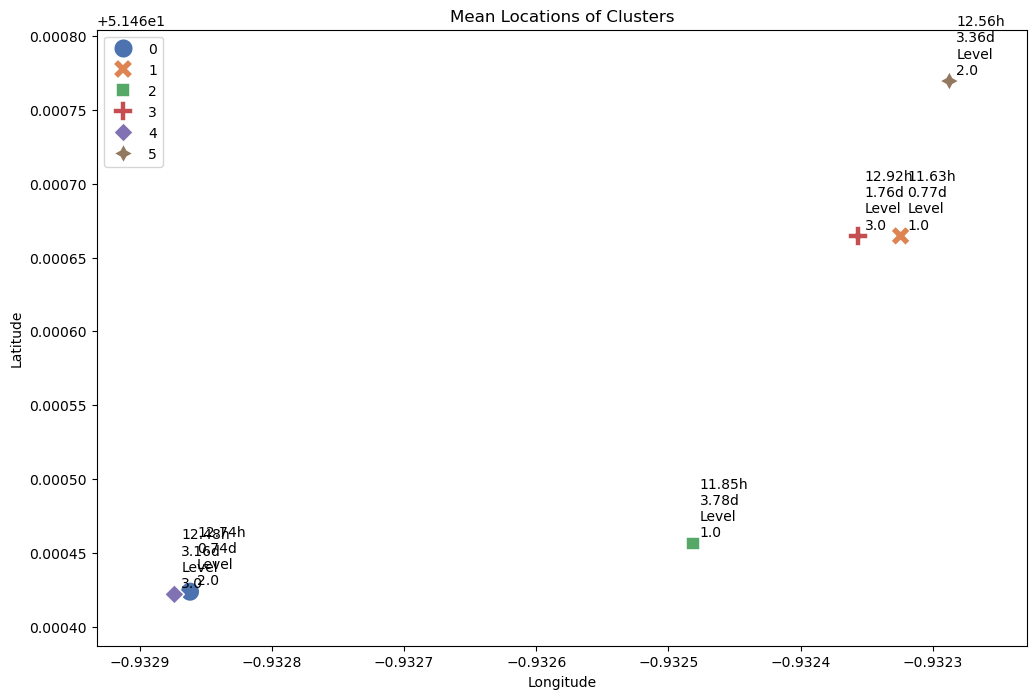

In [131]:
#cluster_analysis = cluster_analysis.reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Create a scatter plot of the mean locations
sns.scatterplot(data=cluster_analysis, x=('lng', 'mean'), y=('lat', 'mean'), 
                hue='Cluster', style='Cluster', s=200, palette='deep')

# Add labels for each point
for idx, row in cluster_analysis.iterrows():
    plt.annotate(f"{row[('hour', 'mean')]:.2f}h\n{row[('day_of_week', 'mean')]:.2f}d\nLevel\n{row[('Level', '<lambda>')]}",
                 (row[('lng', 'mean')], row[('lat', 'mean')]),
                 xytext=(5, 5), textcoords='offset points')

# Customize the plot
plt.title('Mean Locations of Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the axis limits to zoom in on the area of interest
lng_min, lng_max = cluster_analysis[('lng', 'mean')].min(), cluster_analysis[('lng', 'mean')].max()
lat_min, lat_max = cluster_analysis[('lat', 'mean')].min(), cluster_analysis[('lat', 'mean')].max()

# Add some padding (10% of the range)
lng_padding = (lng_max - lng_min) * 0.1
lat_padding = (lat_max - lat_min) * 0.1

plt.xlim(lng_min - lng_padding, lng_max + lng_padding)
plt.ylim(lat_min - lat_padding, lat_max + lat_padding)

# Add a legend
plt.legend(loc='upper left')
plt.show()

In [10]:
df = sample1

# Convert 'localtime' to datetime
df['localtime'] = pd.to_datetime(df['localtime'], errors='coerce')

# Sort by 'ClientMacAddr' and 'localtime'
df = df.sort_values(by=['ClientMacAddr', 'localtime'])

# Dictionary to track if a device is mobile or fixed
device_status = {}

# Define a function to calculate distance between two lat/lng pairs
def calculate_distance(row1, row2):
    coords_1 = (row1['lat'], row1['lng'])
    coords_2 = (row2['lat'], row2['lng'])
    return geodesic(coords_1, coords_2).meters

# Define distance and time thresholds
distance_threshold = 1  # in meters
time_threshold = 5

# Check if a device has moved within a period of time
movement_data = []

for client in df['ClientMacAddr'].unique():
    client_data = df[df['ClientMacAddr'] == client].reset_index(drop=True)

    # Assume devices are fixed unless movement is detected
    is_mobile = False

    for i in range(1, len(client_data)):
        # Get consecutive rows
        row1 = client_data.iloc[i - 1]
        row2 = client_data.iloc[i]
        
        # Calculate the time difference in minutes or hours
        time_diff = (row2['localtime'] - row1['localtime']).total_seconds() / 3600  # Time difference in hours
        
        # Calculate the distance between the two points
        distance = calculate_distance(row1, row2)
        
        # Record the movement
        movement_data.append({
            'ClientMacAddr': client,
            'StartTime': row1['localtime'],
            'EndTime': row2['localtime'],
            'DistanceMoved(m)': distance,
            'TimeDifference(hr)': time_diff
        })

        # If device moved more than the threshold and within the time threshold, it's mobile
        if distance > distance_threshold and time_diff <= time_threshold:
            is_mobile = True
            break  # No need to check further, label it as mobile if condition is met

    # Store device label: 'mobile' or 'fixed'
    device_status[client] = 'mobile' if is_mobile else 'fixed'

# Create a DataFrame with the movement results
movement_df = pd.DataFrame(movement_data)

# Display the movement data
#movement_df

# Add the label to the original DataFrame
df['DeviceType'] = df['ClientMacAddr'].map(device_status)
df

,ClientMacAddr,lat,lng,localtime,DeviceType
4475,00:08:22:2a:bc:fb,51.460374,-0.932532,2020-03-06 11:10:56.643000+00:00,fixed
8245,00:0a:f5:40:18:c0,51.460492,-0.933038,2019-12-11 09:38:48.864000+00:00,fixed
1608,00:0b:82:d0:ff:35,51.460421,-0.932573,2020-05-06 15:47:38.231000+00:00,fixed
9,00:10:20:ce:df:1d,51.460497,-0.932334,2020-02-28 10:26:39.099000+00:00,fixed
1696,00:21:6b:fb:e8:cf,51.460417,-0.932933,2019-08-13 14:33:38.021000+00:00,fixed
...,...,...,...,...,...
4146,fc:03:9f:07:af:f4,51.460809,-0.932313,2020-08-24 09:35:36.581000+00:00,mobile
503,fc:03:9f:07:af:f4,51.460809,-0.932311,2020-08-27 17:34:08.249000+00:00,mobile
532,fc:03:9f:07:af:f4,51.460813,-0.932311,NaT,mobile
4044,fc:03:9f:07:af:f4,51.460805,-0.932314,NaT,mobile


In [48]:
df['localtime'] = pd.to_datetime(df['localtime'], errors='coerce')
def is_fixed(group):
    # Check if latitude and longitude are constant
    lat_constant = group['lat'].nunique() == 1
    lng_constant = group['lng'].nunique() == 1
    return 'Fixed' if (lat_constant and lng_constant) else 'Mobile'

# Group by ClientMacAddr, apply the is_fixed function, and map the result back to each row
df['DeviceType'] = df['ClientMacAddr'].map(df.groupby('ClientMacAddr').apply(is_fixed))
df

# # Group by ClientMacAddr and apply the is_fixed function
# device_type = df.groupby('ClientMacAddr').apply(is_fixed, meta=('DeviceType', 'object'))

# # Merge the device type back to the main dataframe
# df = df.merge(device_type.to_frame('DeviceType'), left_on='ClientMacAddr', right_index=True)

C:\Users\ctric\AppData\Local\Temp\ipykernel_19156\4273313892.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['DeviceType'] = df['ClientMacAddr'].map(df.groupby('ClientMacAddr').apply(is_fixed))


,ClientMacAddr,lat,lng,localtime,DeviceType
0,cc:73:14:60:68:97,51.460419,-0.933088,2020-01-09 11:50:15.478000+00:00,Mobile
1,88:66:a5:1f:0b:05,51.460657,-0.932341,2020-03-10 12:21:09.003000+00:00,Mobile
2,48:45:20:37:e8:c1,51.460403,-0.932967,2020-01-13 10:29:05.560000+00:00,Fixed
3,e4:a7:a0:99:dd:51,51.460825,-0.932265,2019-09-12 14:43:35.368000+00:00,Mobile
4,48:45:20:37:d1:6f,51.460465,-0.933087,2019-10-17 14:33:51.342000+00:00,Mobile
...,...,...,...,...,...
9995,48:a4:72:ae:11:5e,51.460488,-0.933043,2019-10-15 10:58:32.244000+00:00,Mobile
9996,88:66:a5:0e:6c:33,51.460589,-0.932388,2020-01-10 02:58:15.845000+00:00,Mobile
9997,34:e1:2d:c6:a8:59,51.460402,-0.932568,2020-03-13 18:27:59.741000+00:00,Mobile
9998,88:66:a5:15:d6:89,51.460823,-0.932265,2019-08-14 13:35:16.645000+00:00,Mobile


In [50]:
df.DeviceType.value_counts()

DeviceType
Mobile    9171
Fixed      829
Name: count, dtype: int64

In [54]:
df[df.DeviceType == 'Fixed']

,ClientMacAddr,lat,lng,localtime,DeviceType
2,48:45:20:37:e8:c1,51.460403,-0.932967,2020-01-13 10:29:05.560000+00:00,Fixed
5,ec:1f:72:2f:fe:50,51.460496,-0.932773,2019-08-13 10:58:54.906000+00:00,Fixed
9,00:10:20:ce:df:1d,51.460497,-0.932334,2020-02-28 10:26:39.099000+00:00,Fixed
10,80:58:f8:d1:f1:11,51.460855,-0.932362,2020-01-08 16:10:16.590000+00:00,Fixed
21,0c:51:01:b7:10:f4,51.460422,-0.932720,2019-11-06 16:49:48.149000+00:00,Fixed
...,...,...,...,...,...
9931,a4:c3:f0:a5:f0:b4,51.460617,-0.932390,2020-02-19 17:37:26.976000+00:00,Fixed
9937,44:91:60:43:5a:52,51.460386,-0.933089,2019-09-09 16:10:58.588000+00:00,Fixed
9943,f8:e9:4e:59:5d:d1,51.460607,-0.932406,2019-12-09 13:48:25.192000+00:00,Fixed
9969,5c:e0:c5:36:e3:2c,51.460469,-0.932767,2019-12-18 10:41:39.069000+00:00,Fixed


In [68]:
df = df.dropna()

In [70]:
df.isnull().sum()

ClientMacAddr    0
lat              0
lng              0
localtime        0
DeviceType       0
hour             0
day_of_week      0
dtype: int64

In [76]:
df.shape

(9990, 8)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract potentially useful features
df['hour'] = df['localtime'].dt.hour
df['day_of_week'] = df['localtime'].dt.dayofweek

# Select features for clustering
features = ['lat', 'lng', 'hour', 'day_of_week']

# Prepare the data for clustering
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
n_clusters = 3  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['DeviceType'] = df['DeviceType']
pca_df['Cluster'] = df['Cluster']

In [94]:
pca_df['hour'] = df['hour']
pca_df['day_of_week'] = df['day_of_week']
pca_df

,PC1,PC2,DeviceType,Cluster,hour,day_of_week
0,-2.008852,0.547356,Mobile,0.0,11.0,3.0
1,0.905552,-0.477539,Mobile,1.0,12.0,1.0
2,-1.766153,-0.670110,Fixed,0.0,10.0,0.0
3,1.816510,0.107715,Mobile,1.0,14.0,3.0
4,-1.816206,0.092686,Mobile,0.0,14.0,3.0
...,...,...,...,...,...,...
9985,-1.595729,-0.254071,Mobile,1.0,17.0,3.0
9986,0.525938,2.387417,Mobile,2.0,9.0,3.0
9987,-0.783540,0.099384,Mobile,1.0,16.0,3.0
9988,1.808002,-0.210104,Mobile,0.0,14.0,2.0


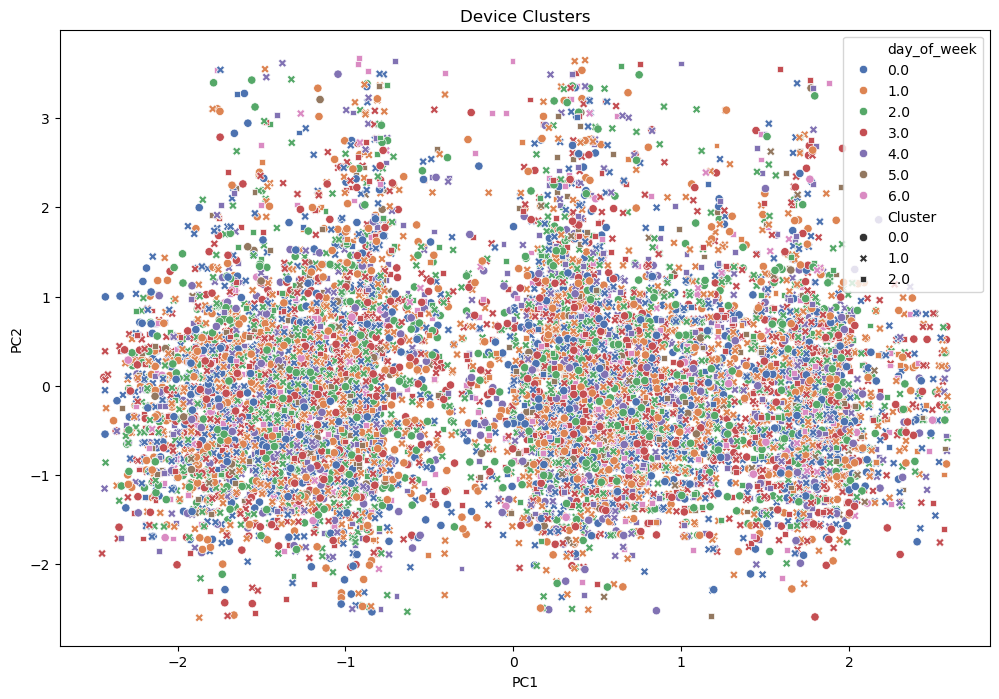

In [98]:
# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='day_of_week', style='Cluster', palette='deep')
plt.title('Device Clusters')
plt.show()

In [107]:
# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']
pca_df['hour'] = df['hour']
pca_df['day_of_week'] = df['day_of_week']
pca_df['Level'] = df['Level']
pca_df

,PC1,PC2,Cluster,hour,day_of_week,Level
0,-1.858773,0.834607,4.0,11.0,3.0,1.0
1,1.280968,-0.006165,1.0,12.0,1.0,0.0
2,1.454199,-0.766305,NaN,NaN,NaN,NaN
3,-1.689998,0.543226,3.0,14.0,3.0,2.0
4,0.888366,0.586715,4.0,14.0,3.0,1.0
...,...,...,...,...,...,...
8212,-1.490657,-0.097306,2.0,19.0,2.0,0.0
8213,0.997362,2.156016,0.0,12.0,0.0,1.0
8214,-1.011831,0.122618,3.0,12.0,1.0,2.0
8215,1.436474,-1.133046,0.0,13.0,1.0,2.0


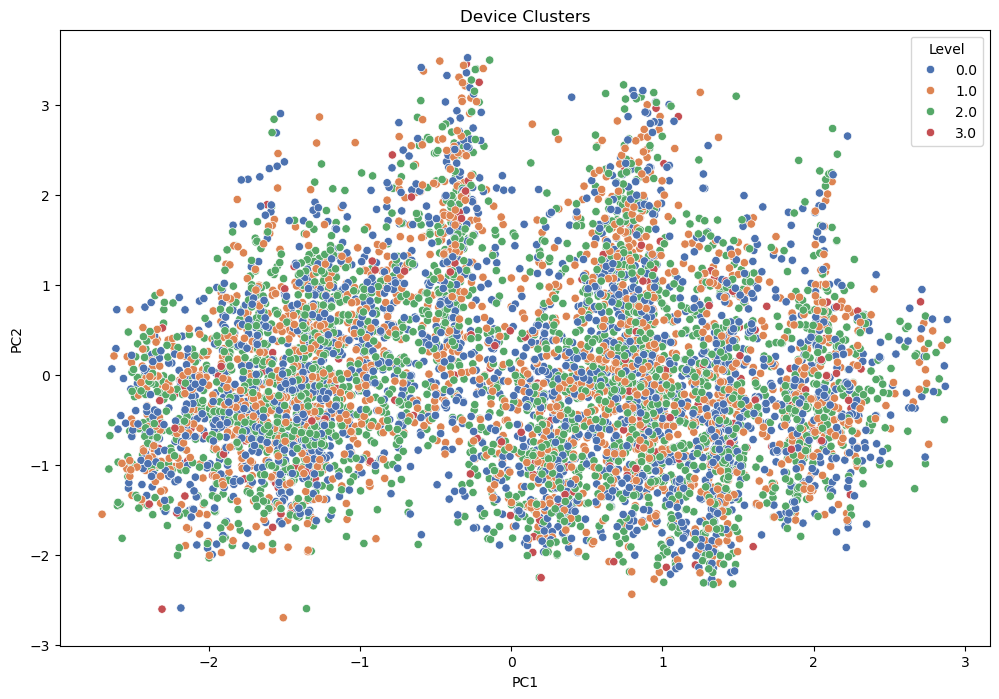

In [111]:
# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Level', palette='deep')
plt.title('Device Clusters')
plt.show()

In [84]:
# Analyze cluster characteristics
cluster_analysis = df.groupby('Cluster').agg({
    'DeviceType': lambda x: x.value_counts().index[0],
    'lat': ['mean', 'std'],
    'lng': ['mean', 'std'],
    'hour': ['mean', 'std'],
    'day_of_week': ['mean', 'std']
})

print("Cluster Analysis:")
cluster_analysis

Cluster Analysis:


DeviceType        lat                 lng                 hour  \
          <lambda>       mean       std      mean       std       mean   
Cluster                                                                  
0           Mobile  51.460422  0.000040 -0.932852  0.000190  13.547659   
1           Mobile  51.460698  0.000131 -0.932324  0.000068  13.519938   
2           Mobile  51.460509  0.000120 -0.932460  0.000169   7.326271   

                  day_of_week            
              std        mean       std  
Cluster                                  
0        3.631586    1.835842  1.453327  
1        3.561517    1.787993  1.437532  
2        4.278278    3.579979  1.606809

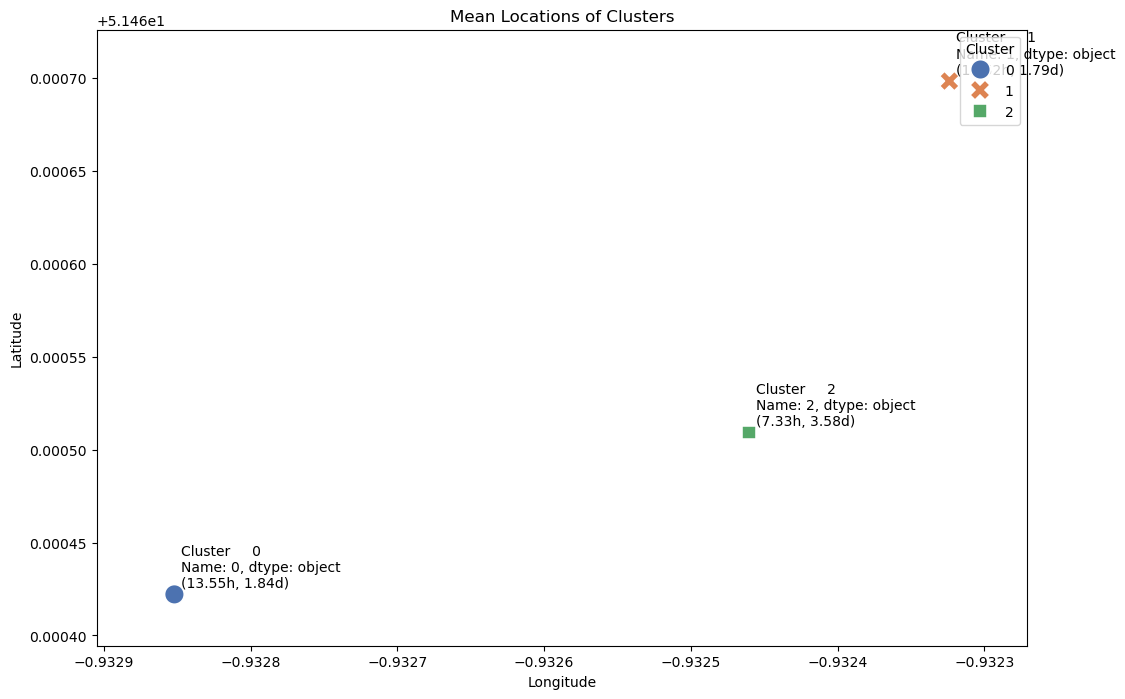

In [102]:
cluster_analysis = cluster_analysis.reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Create a scatter plot of the mean locations
sns.scatterplot(data=cluster_analysis, x=('lng', 'mean'), y=('lat', 'mean'), 
                hue='Cluster', style='Cluster', s=200, palette='deep')

# Add labels for each point
for idx, row in cluster_analysis.iterrows():
    plt.annotate(f"Cluster {row['Cluster']}\n({row[('hour', 'mean')]:.2f}h, {row[('day_of_week', 'mean')]:.2f}d)",
                 (row[('lng', 'mean')], row[('lat', 'mean')]),
                 xytext=(5, 5), textcoords='offset points')

# Customize the plot
plt.title('Mean Locations of Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the axis limits to zoom in on the area of interest
lng_min, lng_max = cluster_analysis[('lng', 'mean')].min(), cluster_analysis[('lng', 'mean')].max()
lat_min, lat_max = cluster_analysis[('lat', 'mean')].min(), cluster_analysis[('lat', 'mean')].max()

# Add some padding (10% of the range)
lng_padding = (lng_max - lng_min) * 0.1
lat_padding = (lat_max - lat_min) * 0.1

plt.xlim(lng_min - lng_padding, lng_max + lng_padding)
plt.ylim(lat_min - lat_padding, lat_max + lat_padding)

# Add a legend
#plt.legend(title='Cluster')
plt.show()

In [86]:
# Analyze differences between fixed and mobile devices
device_type_analysis = df.groupby('DeviceType').agg({
    'lat': ['mean', 'std'],
    'lng': ['mean', 'std'],
    'hour': ['mean', 'std'],
    'day_of_week': ['mean', 'std']
})

print("\nDevice Type Analysis:")
device_type_analysis


Device Type Analysis:


lat                 lng                 hour            \
                 mean       std      mean       std       mean       std   
DeviceType                                                                 
Fixed       51.460587  0.000177 -0.932544  0.000309  12.506039  3.107694   
Mobile      51.460561  0.000163 -0.932539  0.000276  12.346103  4.554818   

           day_of_week            
                  mean       std  
DeviceType                        
Fixed         1.839372  1.391647  
Mobile        2.171360  1.648482

In [28]:
df = sample1

# Group by 'ClientMacAddr' and check if the lat and lng are constant
def classify_device(group):
    if group['lat'].nunique() == 1 and group['lng'].nunique() == 1:
        return 'fixed'
    else:
        return 'mobile'

# Apply the classification and create a new column 'DeviceType'
df['DeviceType'] = df.groupby('ClientMacAddr').apply(lambda group: classify_device(group)).reset_index(drop=True).reindex(df.index)

df

C:\Users\ctric\AppData\Local\Temp\ipykernel_19156\4217729079.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['DeviceType'] = df.groupby('ClientMacAddr').apply(lambda group: classify_device(group)).reset_index(drop=True).reindex(df.index)


,ClientMacAddr,lat,lng,localtime,DeviceType
0,cc:73:14:60:68:97,51.460419,-0.933088,2020-01-09 11:50:15.478 UTC,fixed
1,88:66:a5:1f:0b:05,51.460657,-0.932341,2020-03-10 12:21:09.003 UTC,fixed
2,48:45:20:37:e8:c1,51.460403,-0.932967,2020-01-13 10:29:05.56 UTC,fixed
3,e4:a7:a0:99:dd:51,51.460825,-0.932265,2019-09-12 14:43:35.368 UTC,fixed
4,48:45:20:37:d1:6f,51.460465,-0.933087,2019-10-17 14:33:51.342 UTC,fixed
...,...,...,...,...,...
9995,48:a4:72:ae:11:5e,51.460488,-0.933043,2019-10-15 10:58:32.244 UTC,NaN
9996,88:66:a5:0e:6c:33,51.460589,-0.932388,2020-01-10 02:58:15.845 UTC,NaN
9997,34:e1:2d:c6:a8:59,51.460402,-0.932568,2020-03-13 18:27:59.741 UTC,NaN
9998,88:66:a5:15:d6:89,51.460823,-0.932265,2019-08-14 13:35:16.645 UTC,NaN


In [30]:
df.DeviceType.value_counts()

DeviceType
mobile    1292
fixed      829
Name: count, dtype: int64

In [38]:
df.DeviceType.isnull().sum()

7879

In [17]:
movement_df = movement_df.dropna()
movement_df

,ClientMacAddr,StartTime,EndTime,DistanceMoved(m),TimeDifference(hr)
0,00:23:a7:e7:96:0c,2019-08-14 03:36:59.239000+00:00,2019-08-14 15:28:58.837000+00:00,6.412686,11.866555
1,00:23:a7:e7:96:0c,2019-08-14 15:28:58.837000+00:00,2019-08-17 10:03:19.329000+00:00,3.529777,66.572359
2,00:23:a7:e7:96:0c,2019-08-17 10:03:19.329000+00:00,2019-08-19 04:48:15.895000+00:00,4.149096,42.749046
3,00:23:a7:e7:96:0c,2019-08-19 04:48:15.895000+00:00,2019-08-21 19:26:37.851000+00:00,4.148093,62.639432
4,00:23:a7:e7:96:0c,2019-08-21 19:26:37.851000+00:00,2019-08-28 05:53:55.565000+00:00,0.321631,154.454921
...,...,...,...,...,...
7872,fc:03:9f:07:af:f4,2020-08-07 00:42:38.986000+00:00,2020-08-11 18:16:48.780000+00:00,2.783950,113.569387
7873,fc:03:9f:07:af:f4,2020-08-11 18:16:48.780000+00:00,2020-08-12 14:23:39.544000+00:00,2.872522,20.114101
7874,fc:03:9f:07:af:f4,2020-08-12 14:23:39.544000+00:00,2020-08-20 10:00:44.867000+00:00,0.712749,187.618145
7875,fc:03:9f:07:af:f4,2020-08-20 10:00:44.867000+00:00,2020-08-24 09:35:36.581000+00:00,0.971001,95.581032


In [19]:
movement_df.isnull().sum()

ClientMacAddr         0
StartTime             0
EndTime               0
DistanceMoved(m)      0
TimeDifference(hr)    0
dtype: int64

In [9]:
variables = ['ClientMacAddr', 'lat', 'lng', 'localtime']
chunks = pd.read_csv('combined.csv', chunksize=100000, usecols=variables) # ['Level', 'ClientMacAddr', 'lat', 'lng', 'localtime']

In [45]:
output = pd.DataFrame()
for chunk in chunks:
    chunk['localtime'] = pd.to_datetime(chunk['localtime'], errors='coerce')
    chunk['year'] = chunk['localtime'].dt.year
    chunk['month'] = chunk['localtime'].dt.month
    #chunk['date'] = chunk['localtime'].dt.date
    #chunk['hour'] = chunk['localtime'].dt.hour
    summary = chunk.groupby(['year', 'month']).size().reset_index(name='count')
    output = pd.concat([output, summary], ignore_index=True)
    #break
output

,year,month,count
0,2020.0,8.0,77568
1,2020.0,9.0,22353
2,2020.0,8.0,99920
3,2020.0,8.0,99900
4,2020.0,8.0,99916
...,...,...,...
3020,2019.0,9.0,99903
3021,2019.0,9.0,99922
3022,2019.0,9.0,99917
3023,2019.0,9.0,99916


In [49]:
group_by_month = output.groupby(['year', 'month']).sum().reset_index()
group_by_month

,year,month,count
0,2019.0,8.0,22524034
1,2019.0,9.0,37864662
2,2019.0,10.0,43503899
3,2019.0,11.0,17819159
4,2019.0,12.0,29606421
5,2020.0,1.0,31311905
6,2020.0,2.0,36343901
7,2020.0,3.0,27336687
8,2020.0,4.0,6160673
9,2020.0,5.0,6285517


In [5]:
group_by_month

NameError: name 'group_by_month' is not defined

In [51]:
group_by_month['count'].sum()

290974654

In [62]:
output = pd.DataFrame()
for chunk in chunks:
    categories = ['Level', 'ClientMacAddr'] # ['Level', 'ClientMacAddr']
    counts = chunk[categories]
    counts.count = 1
    summary = counts.groupby(categories).sum().reset_index()
    output = pd.concat([output, summary], ignore_index=True)
output

,Level,ClientMacAddr,count
0,1st Floor,00:08:22:d4:bc:fb,1
1,1st Floor,00:10:20:ce:ba:b5,15
2,1st Floor,00:80:92:df:7b:97,480
3,1st Floor,00:b3:62:32:00:f3,13
4,1st Floor,00:b3:62:4e:0f:c9,1
...,...,...,...
1008241,Ground Floor,ec:ad:b8:8d:92:cf,263
1008242,Ground Floor,f0:18:98:64:a6:4b,424
1008243,Ground Floor,f0:18:98:91:4f:93,424
1008244,Ground Floor,f0:76:6f:79:ea:44,424


In [64]:
group_by_level_mac = output.groupby(categories).sum().reset_index()
group_by_level_mac

,Level,ClientMacAddr,count
0,1st Floor,00:07:88:d8:94:64,52
1,1st Floor,00:08:22:00:b9:fb,14
2,1st Floor,00:08:22:0a:b9:fb,1
3,1st Floor,00:08:22:0a:c3:fb,8
4,1st Floor,00:08:22:0c:bc:fb,1
...,...,...,...
157703,Ground Floor,fc:db:b3:30:28:c9,44
157704,Ground Floor,fc:db:b3:48:91:1e,62
157705,Ground Floor,fc:de:90:27:c1:37,13
157706,Ground Floor,fc:de:90:84:f8:91,14


In [66]:
group_by_level_mac['count'].sum()

291645771

In [58]:
group_by_mac

,ClientMacAddr,count
0,00:00:00:00:00:00,877
1,00:00:11:11:31:10,32
2,00:02:f7:2f:7a:d1,13
3,00:04:4b:62:90:4e,12
4,00:06:c6:5a:a2:51,42
...,...,...
124440,fc:f8:ae:5a:6f:ea,338
124441,fc:fc:48:36:16:6b,251
124442,fd:6a:eb:32:d4:cd,13
124443,fd:9a:58:da:cb:ea,13


In [51]:
group_by_mac['count'].sum()

291645771

In [39]:
group_by_level = output.groupby(categories).sum().reset_index()
group_by_level

,Level,count
0,1st Floor,73867190
1,2nd Floor,101869367
2,3rd Floor,9082026
3,Ground Floor,106827101
4,Level,87


In [41]:
group_by_level['count'].sum()

291645771

In [17]:
final_output = output.groupby(categories).sum().reset_index()
final_output

,Site,count
0,Site,3
1,UK Office,10645768


In [35]:
null_counts_overall = pd.Series(dtype=int)  # To store the total null counts across all chunks

for chunk in chunks:   
    # Calculate null values in the current chunk
    null_counts_chunk = chunk.isnull().sum()

    # Add the null counts of this chunk to the overall count
    null_counts_overall = null_counts_overall.add(null_counts_chunk, fill_value=0)

# After the loop, `null_counts_overall` contains the total number of nulls for each column across all chunks
null_counts_overall

Series([], dtype: int32)

In [37]:
empty_counts_overall = pd.Series(dtype=int)
for chunk in chunks:   
    empty_counts_chunk = chunk.applymap(lambda x: x == '').sum()  # Count empty strings
    empty_counts_overall = empty_counts_overall.add(empty_counts_chunk, fill_value=0)
empty_counts_overall

Series([], dtype: int32)

## Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

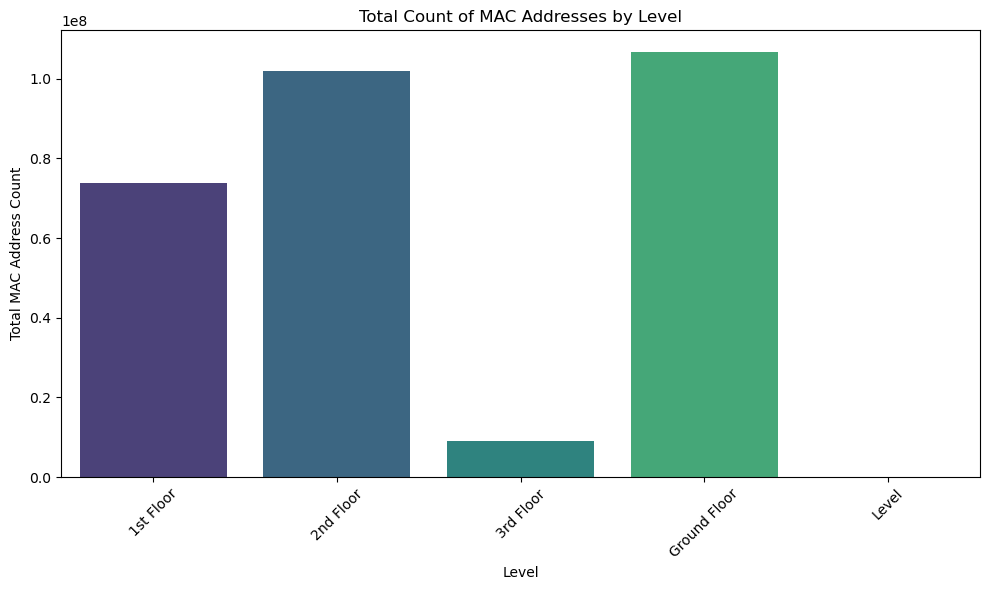

In [ ]:
# Plotting the total count of MAC addresses per level
plt.figure(figsize=(10, 6))
sns.barplot(x='Level', y='count', hue='Level', data=group_by_level, palette='viridis')

# Adding labels and title
plt.xlabel('Level')
plt.ylabel('Total MAC Address Count')
plt.title('Total Count of MAC Addresses by Level')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [209]:
sample_level = pd.DataFrame(sample1.Level.value_counts())
sample_level

,count
Level,
Ground Floor,3623
2nd Floor,3496
1st Floor,2577
3rd Floor,304


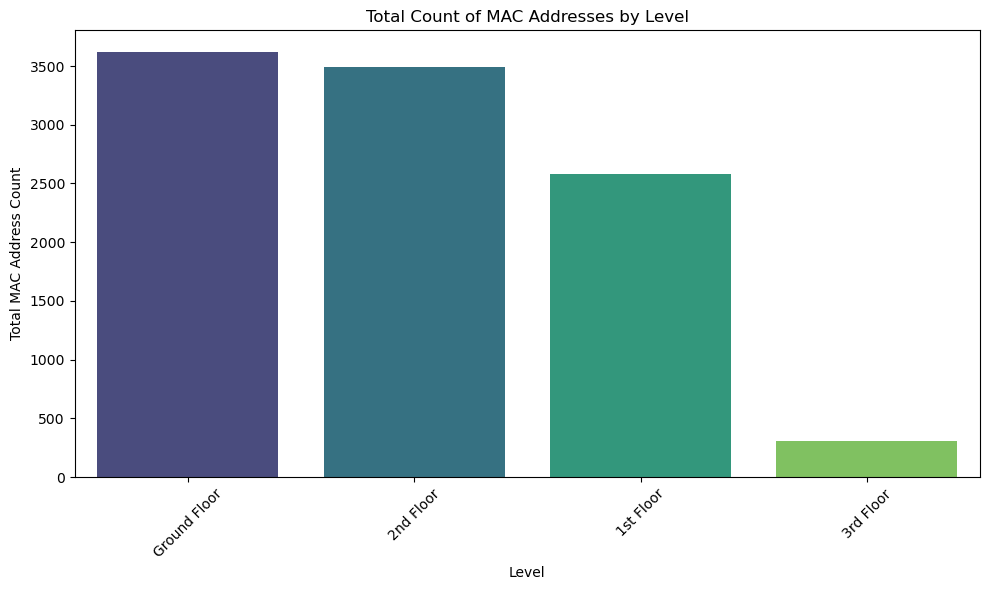

In [211]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Level', y='count', hue='Level', data=sample_level, palette='viridis')

# Adding labels and title
plt.xlabel('Level')
plt.ylabel('Total MAC Address Count')
plt.title('Total Count of MAC Addresses by Level')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Aggregated Dataset

In [82]:
agg.date = pd.to_datetime(agg.date, errors='coerce')
agg['month'] = agg['date'].dt.month
agg['year'] = agg['date'].dt.year
agg['day_of_week'] = agg['date'].dt. dayofweek
agg

,Site,Level,date,hour,visits,month,year,day_of_week
0,UK Office,1st Floor,2019-08-12,18,1907,8,2019,0
1,UK Office,1st Floor,2019-08-12,19,2720,8,2019,0
2,UK Office,1st Floor,2019-08-12,20,3066,8,2019,0
3,UK Office,1st Floor,2019-08-12,21,2717,8,2019,0
4,UK Office,1st Floor,2019-08-12,22,2659,8,2019,0
...,...,...,...,...,...,...,...,...
30913,UK Office,Ground Floor,2020-09-01,19,6365,9,2020,1
30914,UK Office,Ground Floor,2020-09-01,20,6196,9,2020,1
30915,UK Office,Ground Floor,2020-09-01,21,6268,9,2020,1
30916,UK Office,Ground Floor,2020-09-01,22,6129,9,2020,1


In [84]:
df = agg.groupby(['day_of_week'])['visits'].sum().reset_index(name='count')
df

,day_of_week,count
0,0,55406194
1,1,62408630
2,2,56872883
3,3,58477947
4,4,35494777
5,5,11714950
6,6,11270303


<Axes: xlabel='day_of_week', ylabel='count'>

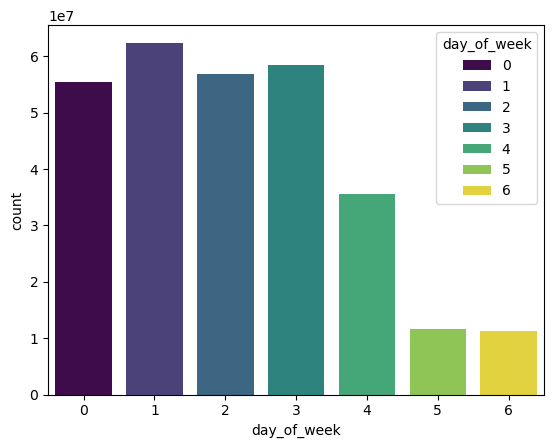

In [88]:
sns.barplot(x='day_of_week', y='count', hue='day_of_week', data=df, palette='viridis')

<Axes: xlabel='hour', ylabel='count'>

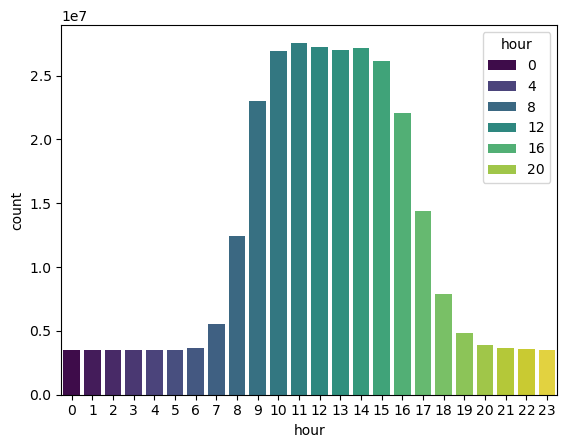

In [80]:
sns.barplot(x='hour', y='count', hue='hour', data=df, palette='viridis')

<Axes: xlabel='Level', ylabel='visits'>

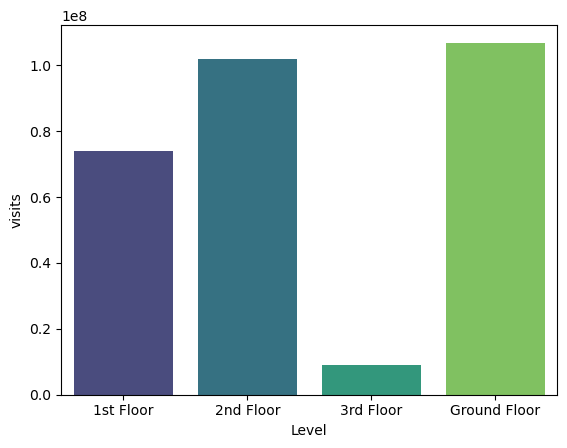

In [25]:
sns.barplot(x='Level', y='visits', hue='Level', data=agg.groupby('Level').sum().reset_index(), palette='viridis')

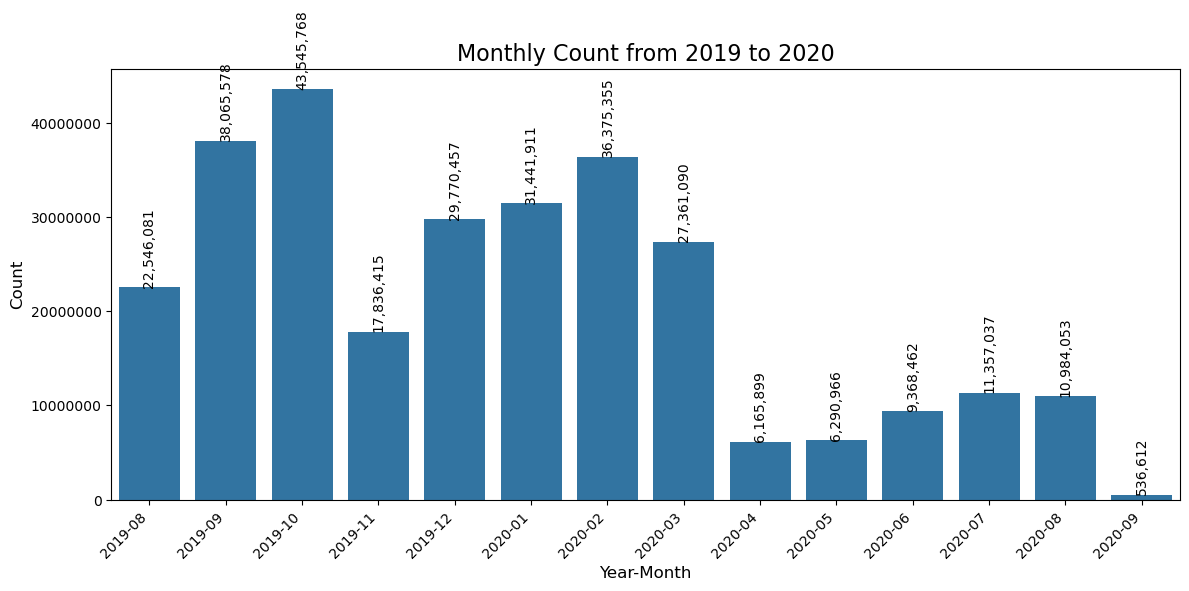

In [60]:

# Create a new column for year-month
df['year_month'] = df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2)

# Sort the DataFrame by year and month
df = df.sort_values(['year', 'month'])

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='year_month', y='count', data=df)

# Customize the plot
plt.title('Monthly Count from 2019 to 2020', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')

# Add value labels on top of each bar
for i, v in enumerate(df['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [60]:
top = final_output.sort_values('count').iloc[-500:]

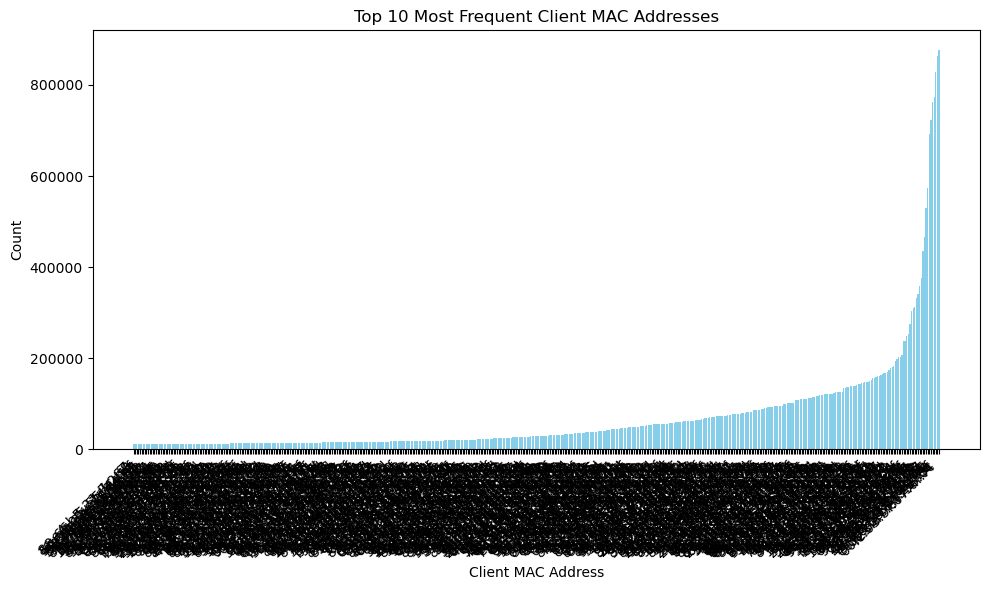

In [62]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(top['ClientMacAddr'], top['count'], color='skyblue')

# Add labels and title
plt.xlabel('Client MAC Address')
plt.ylabel('Count')
plt.title('Top 10 Most Frequent Client MAC Addresses')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of tick-labels
plt.show()